In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# GPU 사용 시 GPU memory 사용량 조절 부분
# 이 코드를 사용하면 GPU memory 가 충분히 남아있을 경우 여러 코드를 동시에 처리할 수 있다.

GPU_DEVICE_NUM = 0 # Multi GPU를 이용할 경우 사용하고자 할 GPU ID
gpus = tf.config.experimental.list_physical_devices('GPU')
print('='*16)
print('Current gpu devices : {}'.format(gpus))
print('='*16)

if gpus :
    try :
        #tf.config.experimental.set_visible_devices(gpus[GPU_DEVICE_NUM], 'GPU')  # Multi GPU 사용 시 주석 제거
        tf.config.experimental.set_memory_growth(gpus[GPU_DEVICE_NUM], True)
    except RuntimeError as e :
        print(e)

Current gpu devices : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# 학습 및 테스트용 CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# 결과 저장 경로
TRAINED_MODEL_PATH = 'models_cifar10'

# Class 개수와 이미지 크기 지정
NUM_CLASSES = 10            # CIFAR-10 Dataset 은 10개의 class 를 가지고 있음
IMG_HEIGHT = 32             # CIFAR-10 Dataset 의 이미지 크기 32x32x3
IMG_WIDTH = 32

# Epoch 횟수와 batch size, learning rate, dropout ratio 지정
EPOCHS = 30                 # 학습 반복 횟수 지정
BATCH_SIZE = 32             # 학습에 사용할 mini-batch 크기
LEARNING_RATE = 0.0001      # Optimizer 에 사용할 learning rate
DROP_OUT_RATIO = 0.5        # AlexNet 에 사용된 Dropout 비율

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
# One-hot encoding 형태로 label 데이터 변경
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [5]:
def AlexNet_cifar10():
    model = tf.keras.Sequential([
        #layer 1
        # 첫 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 3-channels
        # Output channel : 96-channels
        # Stride : 1
        # Activation : ReLU
        tf.keras.layers.Conv2D(filters=96,                              # 출력 channel 개수
                              kernel_size=(3, 3),                       # Convolution kernel size
                              strides=1,                                # stride
                              padding='same',                           # zero-padding 사용여부 'same' : 사용 / 'valid' : 미사용
                              activation=tf.keras.activations.relu,     # 활성함수 지정(ReLU)
                              input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  # 입력 영상 사이즈 지정(첫번째 layer에만 지정)
        # Overlapped Pooling
        # Window size : 3x3
        # Stride : 2
        tf.keras.layers.MaxPool2D(pool_size=(3, 3),                     # Pooling window 크기 (3x3)
                                 strides=2,                             # stride 2
                                 padding='same'),                       # zero-padding 사용여부
        # Batch Normalization
        tf.keras.layers.BatchNormalization(),                           # Batch normalization
        
        #layer 2
        # 두 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 96-channels
        # Output channel : 256-channels
        # Stride : 1
        # Activation : ReLU
        tf.keras.layers.Conv2D(filters=256,                             # 출력 channel 개수
                              kernel_size=(3, 3),                       # Convolution kernel size
                              strides=1,                                # stride
                              padding='same',                           # zero-padding 사용여부 'same' : 사용 / 'valid' : 미사용
                              activation=tf.keras.activations.relu),    # 활성함수 지정(ReLU)
        # Overlapped Pooling
        # Window size : 3x3
        # Stride : 2
        tf.keras.layers.MaxPool2D(pool_size=(3, 3),                     # Pooling window 크기 (3x3)
                                 strides=2,                             # stride 2
                                 padding='same'),                       # zero-padding 사용여부
        # Batch Normalization
        tf.keras.layers.BatchNormalization(),                           # Batch normalization
        
        #layer 3
        # 세 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 256-channels
        # Output channel : 384-channels
        # Stride : 1
        # Activation : ReLU
        tf.keras.layers.Conv2D(filters=384,                             # 출력 channel 개수
                              kernel_size=(3, 3),                       # Convolution kernel size
                              strides=1,                                # stride
                              padding='same',                           # zero-padding 사용여부 'same' : 사용 / 'valid' : 미사용
                              activation=tf.keras.activations.relu),    # 활성함수 지정(ReLU)
        
        #layer 4
        # 네 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 384-channels
        # Output channel : 384-channels
        # Stride : 1
        # Activation : ReLU        
        tf.keras.layers.Conv2D(filters=384,                             # 출력 channel 개수
                              kernel_size=(3, 3),                       # Convolution kernel size
                              strides=1,                                # stride
                              padding='same',                           # zero-padding 사용여부 'same' : 사용 / 'valid' : 미사용
                              activation=tf.keras.activations.relu),    # 활성함수 지정(ReLU)
        
        #layer 5
        # 다섯 번째 convolution layer
        # Kernel size : 3x3
        # Input channel : 384-channels
        # Output channel : 256-channels
        # Stride : 1
        # Activation : ReLU 
        tf.keras.layers.Conv2D(filters=256,                             # 출력 channel 개수
                              kernel_size=(3, 3),                       # Convolution kernel size
                              strides=1,                                # stride
                              padding='same',                           # zero-padding 사용여부 'same' : 사용 / 'valid' : 미사용
                              activation=tf.keras.activations.relu),    # 활성함수 지정(ReLU)
        # Overlapped Pooling
        # Window size : 3x3
        # Stride : 2
        tf.keras.layers.MaxPool2D(pool_size=(3, 3),                     # Pooling window 크기 (3x3)
                                 strides=2,                             # stride 2
                                 padding='same'),                       # zero-padding 사용여부
        # Batch Normalization
        tf.keras.layers.BatchNormalization(),                           # Batch normalization
        
        #layer 6
        # Flatten() : (Batch, Height, Width, Channel) -> (Batch, Height*Width*Channel)
        tf.keras.layers.Flatten(),
        # Dense Layer
        # Input Units : Height*Width*Channel
        # Output Units : 4096
        # Activation : ReLU
        tf.keras.layers.Dense(units=4096,                               # Dense layer 출력 개수
                             activation=tf.keras.activations.relu),     # 활성함수 지정(ReLU)
        tf.keras.layers.Dropout(rate=DROP_OUT_RATIO),                   # Dropout
        
        #layer 7
        # Dense Layer
        # Input Units : 4096
        # Output Units : 4096
        # Activation : ReLU
        tf.keras.layers.Dense(units=4096,                               # Dense layer 출력 개수
                             activation=tf.keras.activations.relu),     # 활성함수 지정(ReLU)
        # Dropout
        tf.keras.layers.Dropout(rate=DROP_OUT_RATIO),                   # Dropout
        
        #layer 8
        # Dense Layer
        # Input Units : 4096
        # Output Units : NUM_CLASSES(CIFAR-10 : 10)
        # Activation : Softmax
        tf.keras.layers.Dense(units=NUM_CLASSES,                        # Dense layer 출력 개수
                             activation=tf.keras.activations.softmax)   # 활성함수 지정(softmax)
    ])
    
    return model                # Keras Sequential Model 로 생성한 AlexNet 리턴

In [6]:
# AlexNet 모델 생성
model = AlexNet_cifar10()

# 학습에 사용할 Adam optimizer 및 loss function 생성
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
losses = tf.keras.losses.CategoricalCrossentropy()

# 모델 컴파일(optimizer, loss 지정)
model.compile(optimizer=optimizer,
              loss=losses,
              metrics=['acc'])

In [7]:
# 모델 summary 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       221440    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         8

In [8]:
# 학습 중 callback 함수 지정
# 학습 과정 상의 loss와 learning rate를 저장하기 위한 class
class LossHistory(tf.keras.callbacks.Callback) :
    # tf.keras.callbacks.Callback 클래스를 상속받아 LossHistory 클래스 생성
    # on_train_begin() 와 on_epoch_end() 메소드를 오버라이딩

    # on_train_begin() : 학습이 시작될 때 동작시킬 메소드
    def on_train_begin(self, logs={}):
        # loss와 learning rate 를 저장시킬 list 생성
        self.losses = []
        self.lr = []

    # on_epoch_end() : epoch 이 종료될 때마다 동작시킬 메소드
    def on_epoch_end(self, batch, logs={}):
        # loss, learning_rate 를 list에 저장
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

# optimizer 에 사용된 learning rate 를 반환하는 함수
def step_decay(epoch):
    lrate = K.eval(model.optimizer.lr)
    return lrate

if os.path.exists(TRAINED_MODEL_PATH) is False :
    os.makedirs(TRAINED_MODEL_PATH)
    
# Checkpoint 저장을 위한 callback
# TRAINED_MODEL_PATH 에 'val_acc' 기준으로 최대값이 갱신될 때마다 저장하도록 구현
save_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=TRAINED_MODEL_PATH,
                monitor='val_acc', verbose=1, save_best_only=True,
                save_weights_only=False, mode='max', save_freq='epoch')

# 필요한 callback 을 list 로 지정
loss_history = LossHistory()
callback_list = [loss_history, save_callback]

# 학습 수행
history = model.fit(x_train, y_train,          # 학습용 image(x_train)과 label(y_train)
                   batch_size=BATCH_SIZE,      # batch size 입력
                   epochs=EPOCHS,              # epoch 횟수 입력
                   validation_split=0.2,       # 매 epoch 학습 종료 시 validation에 사용할 데이터 비율 설정(20%)
                   shuffle=True,               # 매 epoch 학습 시작 전 데이터셋 무작위로 배치
                   callbacks=[callback_list])  # 매 epoch이 종료될 때 호출할 callback 함수 지정

Epoch 1/30
1250/1250 [==============================] - 21s 13ms/step - loss: 1.4501 - acc: 0.4980 - val_loss: 1.0592 - val_acc: 0.6202

Epoch 00001: val_acc improved from -inf to 0.62020, saving model to models_cifar10
INFO:tensorflow:Assets written to: models_cifar10\assets
Epoch 2/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9425 - acc: 0.6693 - val_loss: 0.9132 - val_acc: 0.6729

Epoch 00002: val_acc improved from 0.62020 to 0.67290, saving model to models_cifar10
INFO:tensorflow:Assets written to: models_cifar10\assets
Epoch 3/30
1250/1250 [==============================] - 20s 16ms/step - loss: 0.7464 - acc: 0.7410 - val_loss: 0.7907 - val_acc: 0.7211

Epoch 00003: val_acc improved from 0.67290 to 0.72110, saving model to models_cifar10
INFO:tensorflow:Assets written to: models_cifar10\assets
Epoch 4/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6149 - acc: 0.7853 - val_loss: 0.7618 - val_acc: 0.7398

Epoch 00004: val_acc impro

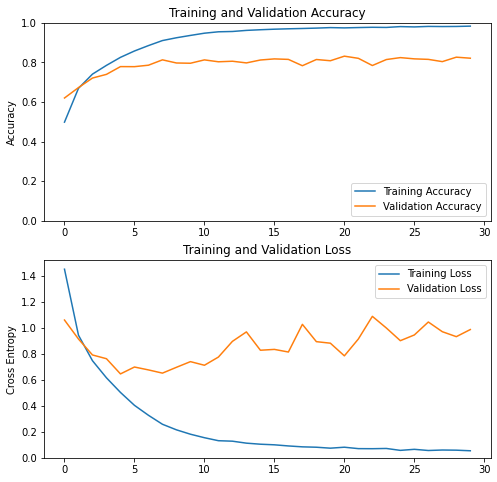

In [9]:
# Training accuracy 및 validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# Training loss 및 validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib 를 이용하여 accuracy 및 loss 출력
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [10]:
# Test 데이터를 이용한 학습 모델 검증
# model.evaluate() 를 통해 모델 검증
test_loss, test_acc = model.evaluate(x_test, y_test,
          batch_size=1, verbose=1)
print('Test Loss : {:.4f}, Test Accuracy : {:.2f}%'.format(test_loss, 100.*test_acc))

10000/10000 [==============================] - 52s 5ms/step - loss: 1.0518 - acc: 0.8155
Test Loss : 1.0518, Test Accuracy : 81.55%
